# Thin Sample Ptychography: A simple example

Tutorial created in collaboration between Diamond and SCD.

*Authors*
- Benedikt Daurer ([benedikt.daurer@diamond.ac.uk]())
- Darren Batey ([darren.batey@diamond.ac.uk]())

The notebook has been adapted to work with the previous notebook (1_forward_model_3d).

## Data collection

### Load test images as the object

In [31]:
image_path_phase = './results/object_field_cross_section_phase.tif'
image_path_modulus = './results/object_field_cross_section_modulus.tif'

### Reconstruction parameters

In [32]:
import json

# Load parameters from parameters.json
with open('./results/parameters.json', 'r') as f:
    params = json.load(f)

scan_points_xy = params['scan_points_xy']
scan_step_size = params['scan_step_size']
detector_shape = params['detector_shape']
probe_diameter = params['probe_diameter']

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def create_probe(shape, radius, signal=1):
    ap = signal*np.ones(shape, dtype=np.complex64)
    radius= np.array(radius)
    cent = np.divide(shape,2)

    x = np.arange(0,np.size(ap,0)) - cent[0]
    y = np.arange(0,np.size(ap,1)) - cent[1]

    yy, xx = np.meshgrid(y, x)
    grid = np.sqrt((xx**2)+(yy**2))
    ap[grid>np.mean(radius)] = 0
    return ap

def create_object(im_mod, im_phase, probe, positions, step):
    n_pos = positions.shape[-1]
    n_pos_x = np.ceil(np.sqrt(n_pos))
    n_pos_y = np.ceil(np.sqrt(n_pos))
    local_shape = probe.shape
    global_shape = np.array(local_shape)
    global_shape[0] += n_pos_y*step
    global_shape[1] += n_pos_x*step
    
    if im_mod is None:
        im_mod = np.ones(global_shape, dtype=np.float32)
    else:
        im_mod = im_mod.resize(global_shape)
        im_mod = np.array(im_mod, dtype=np.float32)
        im_mod -= np.min(im_mod)
        im_mod /= np.max(im_mod)
    if im_phase is None:
        im_phase = np.zeros(global_shape, dtype=np.float32)
    else:
        im_phase = im_phase.resize(global_shape)
        im_phase = np.array(im_phase, dtype=np.float32)
        im_phase -= np.min(im_phase)
        im_phase /= np.max(im_phase)
        im_phase *= np.pi
    
    obj = im_mod * np.exp(1j * im_phase)
    return obj

def create_positions(n, step):
    forward = True
    position_number = 0
    pos = np.zeros([2, n*n], dtype=np.int32)

    for j in range(n):
        for i in range(n):
            if forward:
                pos[1, position_number] = i * step
                pos[0, position_number] = j * step
            else:
                pos[1, position_number] = (n-i-1) * step
                pos[0, position_number] = j * step
            position_number += 1
        forward = not forward
    
    pos[0,:] = pos[0,:] - np.floor(np.mean(pos[0,:]))
    pos[1,:] = pos[1,:] - np.floor(np.mean(pos[1,:]))
    return pos


def cut(ar, pos, shape):
    centre = np.divide(shape, 2)
    centre = np.floor(centre)
    shape = np.int32(np.round(shape))
    pos[0] = pos[0] - np.floor(shape[0]/2)
    pos[1] = pos[1] - np.floor(shape[1]/2)
    ar_cut = np.copy(ar[pos[0]:(pos[0] + shape[0]), pos[1]:(pos[1] + shape[1])])
    return ar_cut


def create_data(obj, probe, positions):
    global_shape = np.int32(obj.shape)
    local_shape = np.int32(probe.shape)
    data = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.float32)
    exit_wave = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.complex64)
    local = np.zeros([positions.shape[1], local_shape[0], local_shape[1]], dtype=np.complex64)
    
    positions[0,:] = positions[0,:] + np.floor(global_shape[0]/2)
    positions[1,:] = positions[1,:] + np.floor(global_shape[1]/2)
    
    for frame_number in range(positions.shape[1]):
        local[frame_number, :, :] = cut(obj, positions[:,frame_number], local_shape)
        exit_wave[frame_number, :, :] = local[frame_number, :, :] * probe
        data[frame_number, :, :] = np.random.poisson(np.square(np.abs(np.fft.fftshift(np.fft.fft2(exit_wave[frame_number, :, :])))))

    return data, exit_wave, local

In [34]:
if image_path_modulus == '':
    im_modulus = None
else:
    im_modulus = Image.open(image_path_modulus)
if image_path_phase == '':
    im_phase = None
else:
    im_phase = Image.open(image_path_phase)

In [35]:
positions = create_positions(scan_points_xy, scan_step_size)
probe = create_probe(detector_shape, probe_diameter/2, signal=1)
obj = create_object(im_modulus,im_phase, probe, positions, scan_step_size)
_, exit_wave, local = create_data(obj, probe, positions)
data = np.load('./results/data.npy')

/tmp/ipykernel_99283/3402313792.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data[1,:,:]))


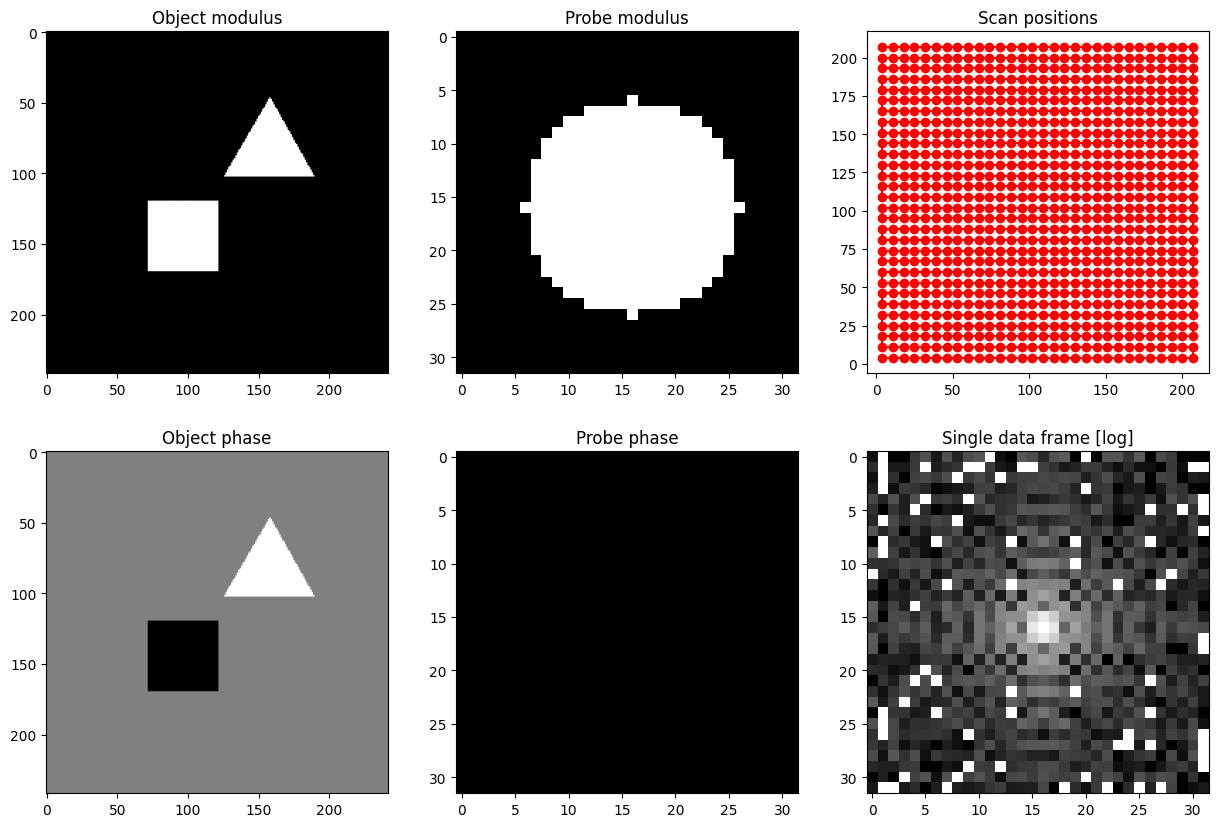

In [36]:
plt.figure('pty data simulation', figsize=[15,10])
plt.gray()
plt.subplot(2,3,1)
plt.title('Object modulus')
plt.imshow(np.abs(obj))
plt.subplot(2,3,4)
plt.title('Object phase')
plt.imshow(np.angle(obj))
plt.subplot(2,3,2)
plt.title('Probe modulus')
plt.imshow(np.abs(probe))
plt.subplot(2,3,5)
plt.title('Probe phase')
plt.imshow(np.angle(probe))
plt.subplot(2,3,3)
plt.title('Scan positions')
plt.plot(positions[1,:], positions[0,:], '-or')
plt.axis('square')
plt.subplot(2,3,6)
plt.title('Single data frame [log]')
plt.imshow(np.log(data[1,:,:]))
plt.show()

## Simple reconstruction from "data and model" notebook

### Reconstruction parameters

In [37]:
num_iterations = 20

In [38]:
from utils import scan_pos_pix, scan_view_limits

In [39]:
# Convert scan positions to pixel units
posx_pix = positions[1,:]
posy_pix = positions[0,:]
# Calculate lower and higher limits for each scan view
xlow, xhigh, ylow, yhigh, xcentre, ycentre = scan_view_limits(posx_pix, posy_pix, probe.shape)
# Create initial object array
obj_shape = (yhigh.max()+1, xhigh.max()+1)
obj = np.ones(obj_shape, dtype=complex)
# Create probe array
initial_probe = np.copy(probe) # in the more general case this can just be an empty array of noise

In [40]:
# Calculate mean power in diffraction data
mean_power = np.mean(np.abs(data))

In [41]:
# Create empty object array
obj = np.ones(obj_shape, dtype=complex)
# Create initial probe array
probe = np.copy(initial_probe) # in the more general case this can just be an empty array of noise

In [42]:
num_positions = len(posx_pix)
alpha = 1e-4
beta = 1
lerror = np.zeros(num_positions)
gerror = np.zeros(num_iterations)
fft_scaling = 1./np.sqrt(np.prod(probe.shape))
positions = np.arange(num_positions)
j = 0

In [43]:
# The main iteration loop
for j in range(num_iterations):
    print("Iteration %d" %j)
    # Randomize the order of the scan positions
    np.random.shuffle(positions)
    
    # Going through all the scan positions
    for i in positions:

            #print("Position %d" %i)
        
            # The object view
            ov  = obj[ylow[i]:yhigh[i],xlow[i]:xhigh[i]]

            # The exit wave view
            ev = probe*ov

            # The model in Fourier space
            fmodel = np.fft.ifftshift(np.fft.fftn((ev))) * fft_scaling

            # Keep track of the error
            lerror[i] = np.sum((np.abs(fmodel)**2 - data[i])**2) / np.prod(fmodel.shape)

            # Apply the data constraint
            fmodel = np.sqrt(data[i]) * np.exp(1j * np.angle(fmodel))

            # New exit wave
            emodel = np.fft.ifftn(np.fft.fftshift(fmodel)) / fft_scaling

            # Power correction for probe
            probe *= np.sqrt(mean_power / (np.abs(probe)**2).mean())

            # Update the object
            ov += beta * np.conj(probe) / np.max(np.abs(probe)**2) * (emodel - ev)

            # Update the probe
            probe += beta * np.conj(ov) / np.max(np.abs(obj)**2) * (emodel - ev)

    # Save average error
    gerror[j] = np.mean(lerror)

    j += 1

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


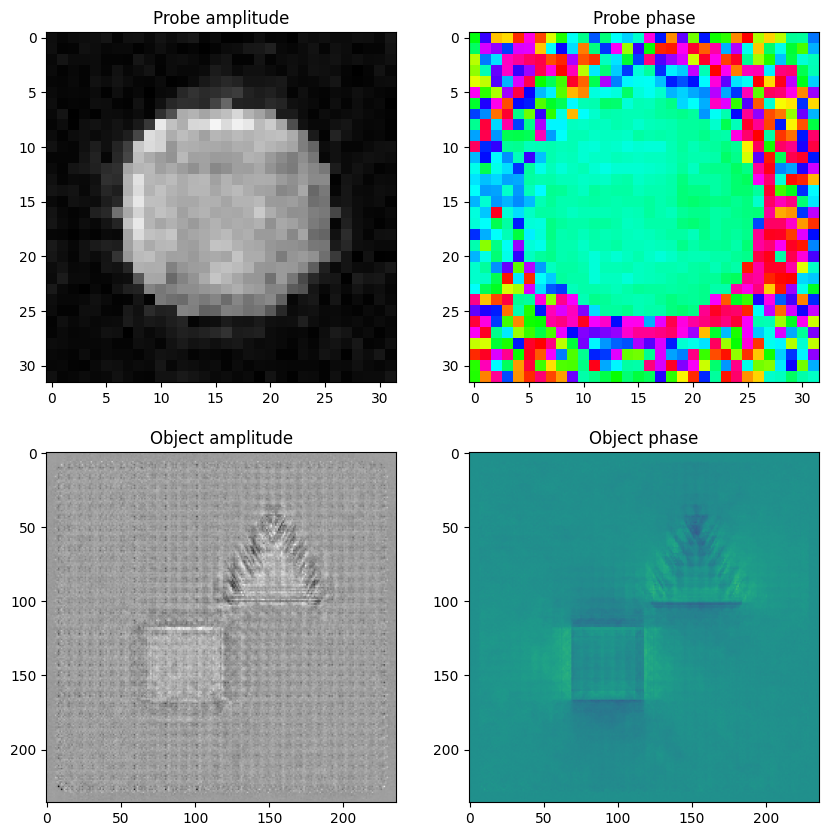

In [44]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axes[0,0].set_title("Probe amplitude")
axes[0,0].imshow(np.abs(probe), vmax=50, cmap='gray')
axes[0,1].set_title("Probe phase")
axes[0,1].imshow(np.angle(probe), cmap='hsv')
axes[1,0].set_title("Object amplitude")
axes[1,0].imshow(np.abs(obj), cmap='gray')
axes[1,1].set_title("Object phase")
axes[1,1].imshow(np.angle(obj), vmin=-np.pi, vmax=np.pi, cmap='viridis')
plt.show()

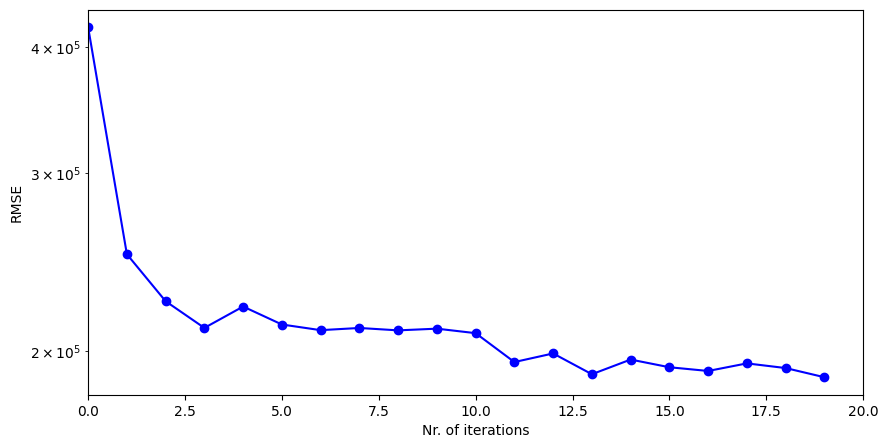

In [45]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(num_iterations), gerror, "bo-")
plt.xlim(0,num_iterations)
plt.semilogy()
plt.xlabel("Nr. of iterations")
plt.ylabel("RMSE")
plt.show()